In [27]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load the dataset
Ames = pd.read_csv('~/Documents/NYCDSA/Third Project/ML_Ames_Housing/data/Ames_Housing_Price_Data.csv', index_col=0)
Ames = Ames.drop(columns=['PID'])
# Convert the below numeric features to categorical features
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')
Ames['YearRemodAdd'] = Ames['YearRemodAdd'].astype('object')
Ames['GarageYrBlt'] = Ames['GarageYrBlt'].astype('str')
Ames['YearBuilt'] = Ames['YearBuilt'].astype('object')
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')

# Exclude 'PID' and 'SalePrice' from features and specifically handle the 'Electrical' column
numeric_features = Ames.select_dtypes(include=['int64', 'float64']).drop(columns=['SalePrice','BsmtFinSF2', 'BsmtUnfSF', 'BsmtFinSF1','1stFlrSF', '2ndFlrSF', 'LowQualFinSF']).columns
categorical_features = Ames.select_dtypes(include=['object']).columns.difference(['Electrical'])
electrical_feature = ['Electrical']

In [28]:
# Manually specify the categories for ordinal encoding according to the data dictionary
ordinal_order = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],  # Electrical system
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],  # General shape of property
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],  # Type of utilities available
    'LandSlope': ['Sev', 'Mod', 'Gtl'],  # Slope of property
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the quality of the material on the exterior
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the present condition of the material on the exterior
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Height of the basement
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # General condition of the basement
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],  # Walkout or garden level basement walls
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of basement finished area
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of second basement finished area
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Heating quality and condition
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Kitchen quality
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Home functionality
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Fireplace quality
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],  # Interior finish of the garage
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage quality
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage condition
    'PavedDrive': ['N', 'P', 'Y'],  # Paved driveway
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],  # Pool quality
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']  # Fence quality
}

# Extract list of ALL ordinal features from dictionary
ordinal_features = list(ordinal_order.keys())

# List of ordinal features except Electrical
ordinal_except_electrical = [feature for feature in ordinal_features if feature != 'Electrical']

# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for 'Electrical': Fill missing value with mode then apply ordinal encoding
electrical_transformer = Pipeline(steps=[
    ('impute_electrical', SimpleImputer(strategy='most_frequent')),
    ('ordinal_electrical', OrdinalEncoder(categories=[ordinal_order['Electrical']]))
])

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [29]:
# Pipeline for ordinal features: Fill missing values with 'None' then apply ordinal encoding
ordinal_transformer = Pipeline(steps=[
    ('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    ('ordinal', OrdinalEncoder(categories=[ordinal_order[feature] for feature in ordinal_except_electrical]))
])
# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
nominal_features = [feature for feature in categorical_features if feature not in ordinal_features]
categorical_transformer = Pipeline(steps=[
    ('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combined preprocessor for numeric, ordinal, nominal, and specific electrical data
preprocessor = ColumnTransformer(
    transformers=[
        ('electrical', electrical_transformer, ['Electrical']),
        ('num', numeric_transformer, numeric_features),
        ('ordinal', ordinal_transformer, ordinal_except_electrical),
        ('nominal', categorical_transformer, nominal_features)
])


# Apply the preprocessing pipeline to Ames
transformed_data = preprocessor.fit_transform(Ames)

# Generate column names for the one-hot encoded features
onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()

In [30]:
# Combine all feature names
all_feature_names = ['Electrical'] + list(numeric_features) + list(ordinal_except_electrical) + list(onehot_features)

In [31]:
 # Convert the transformed array to a DataFrame
transformed_df = pd.DataFrame(transformed_data.toarray(), columns=all_feature_names)

# # Optional command for expanded view
 # pd.set_option('display.max_columns', None)

# View the transformation
# print(transformed_df)

#Quick way to cross-check number of columns after preprocessing
#print(len(numeric_features) + len(ordinal_features) + Ames[nominal_features].fillna("None").nunique().sum())
transformed_df

,Electrical,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,x0_Grvl,x0_None,x0_Pave,x1_1Fam,x1_2fmCon,x1_Duplex,x1_Twnhs,x1_TwnhsE,x2_N,x2_Y,x3_Artery,x3_Feedr,x3_Norm,x3_PosA,x3_PosN,x3_RRAe,x3_RRAn,x3_RRNe,x3_RRNn,x4_Artery,x4_Feedr,x4_Norm,x4_PosA,x4_PosN,x4_RRAe,x4_RRAn,x4_RRNn,x5_AsbShng,x5_AsphShn,x5_BrkComm,x5_BrkFace,x5_CBlock,x5_CemntBd,x5_HdBoard,x5_ImStucc,x5_MetalSd,x5_Plywood,x5_PreCast,x5_Stucco,x5_VinylSd,x5_Wd Sdng,x5_WdShing,x6_AsbShng,x6_AsphShn,x6_Brk Cmn,x6_BrkFace,x6_CBlock,x6_CmentBd,x6_HdBoard,x6_ImStucc,x6_MetalSd,x6_Plywood,x6_PreCast,x6_Stone,x6_Stucco,x6_VinylSd,x6_Wd Sdng,x6_Wd Shng,x7_BrkTil,x7_CBlock,x7_PConc,x7_Slab,x7_Stone,x7_Wood,x8_2Types,x8_Attchd,x8_Basment,x8_BuiltIn,x8_CarPort,x8_Detchd,x8_None,x9_1895.0,x9_1900.0,x9_1906.0,x9_1908.0,x9_1910.0,x9_1914.0,x9_1915.0,x9_1916.0,x9_1917.0,x9_1918.0,x9_1920.0,x9_1921.0,x9_1922.0,x9_1923.0,x9_1924.0,x9_1925.0,x9_1926.0,x9_1927.0,x9_1928.0,x9_1929.0,x9_1930.0,x9_1931.0,x9_1932.0,x9_1933.0,x9_1934.0,x9_1935.0,x9_1936.0,x9_1937.0,x9_1938.0,x9_1939.0,x9_1940.0,x9_1941.0,x9_1942.0,x9_1943.0,x9_1945.0,x9_1946.0,x9_1947.0,x9_1948.0,x9_1949.0,x9_1950.0,x9_1951.0,x9_1952.0,x9_1953.0,x9_1954.0,x9_1955.0,x9_1956.0,x9_1957.0,x9_1958.0,x9_1959.0,x9_1960.0,x9_1961.0,x9_1962.0,x9_1963.0,x9_1964.0,x9_1965.0,x9_1966.0,x9_1967.0,x9_1968.0,x9_1969.0,x9_1970.0,x9_1971.0,x9_1972.0,x9_1973.0,x9_1974.0,x9_1975.0,x9_1976.0,x9_1977.0,x9_1978.0,x9_1979.0,x9_1980.0,x9_1981.0,x9_1982.0,x9_1983.0,x9_1984.0,x9_1985.0,x9_1986.0,x9_1987.0,x9_1988.0,x9_1989.0,x9_1990.0,x9_1991.0,x9_1992.0,x9_1993.0,x9_1994.0,x9_1995.0,x9_1996.0,x9_1997.0,x9_1998.0,x9_1999.0,x9_2000.0,x9_2001.0,x9_2002.0,x9_2003.0,x9_2004.0,x9_2005.0,x9_2006.0,x9_2007.0,x9_2008.0,x9_2009.0,x9_2010.0,x9_nan,x10_Floor,x10_GasA,x10_GasW,x10_Grav,x10_OthW,x10_Wall,x11_1.5Fin,x11_1.5Unf,x11_1Story,x11_2.5Fin,x11_2.5Unf,x11_2Story,x11_SFoyer,x11_SLvl,x12_Bnk,x12_HLS,x12_Low,x12_Lvl,x13_Corner,x13_CulDSac,x13_FR2,x13_FR3,x13_Inside,x14_20,x14_30,x14_40,x14_45,x14_50,x14_60,x14_70,x14_75,x14_80,x14_85,x14_90,x14_120,x14_150,x14_160,x14_180,x14_190,x15_A (agr),x15_C (all),x15_FV,x15_I (all),x15_RH,x15_RL,x15_RM,x16_BrkCmn,x16_BrkFace,x16_None,x16_Stone,x17_Gar2,x17_None,x17_Othr,x17_Shed,x17_TenC,x18_1,x18_2,x18_3,x18_4,x18_5,x18_6,x18_7,x18_8,x18_9,x18_10,x18_11,x18_12,x19_Blmngtn,x19_Blueste,x19_BrDale,x19_BrkSide,x19_ClearCr,x19_CollgCr,x19_Crawfor,x19_Edwards,x19_Gilbert,x19_Greens,x19_GrnHill,x19_IDOTRR,x19_Landmrk,x19_MeadowV,x19_Mitchel,x19_NAmes,x19_NPkVill,x19_NWAmes,x19_NoRidge,x19_NridgHt,x19_OldTown,x19_SWISU,x19_Sawyer,x19_SawyerW,x19_Somerst,x19_StoneBr,x19_Timber,x19_Veenker,x20_CompShg,x20_Membran,x20_Metal,x20_Roll,x20_Tar&Grv,x20_WdShake,x20_WdShngl,x21_Flat,x21_Gable,x21_Gambrel,x21_Hip,x21_Mansard,x21_Shed,x22_Abnorml,x22_AdjLand,x22_Alloca,x22_Family,x22_Normal,x22_Partial,x23_COD,x23_CWD,x23_Con,x23_ConLD,x23_ConLI,x23_ConLw,x23_New,x23_Oth,x23_VWD,x23_WD,x24_Grvl,x24_Pave,x25_1872,x25_1875,x25_1879,x25_1880,x25_1882,x25_1885,x25_1890,x25_1892,x25_1893,x25_1895,x25_1898,x25_1900,x25_1902,x25_1904,x25_1905,x25_1906,x25_1908,x25_1910,x25_1912,x25_1913,x25_1914,x25_1915,x25_1916,x25_1917,x25_1918,x25_1919,x25_1920,x25_1921,x25_1922,x25_1923,x25_1924,x25_1925,x25_1926,x25_1927,x25_1928,x25_1929,x25_1930,x25_1931,x25_1932,x25_1934,x25_1935,x25_1936,x25_1937,x25_1938,x25_1939,x25_1940,x25_1941,x25_1942,x25_1945,x25_1946,x25_1947,x25_1948,x25_1949,x25_1950,x25_1951,x25_1952,x25_1953,x25_1954,x25_1955,x25_1956,x25_1957,x25_1958,x25_1959,x25_1960,x25_1961,x25_1962,x25_1963,x25_1964,x25_

In [32]:
from sklearn.ensemble import RandomForestRegressor
# Assuming RandomForest is part of your models dictionary
random_forest_model = RandomForestRegressor(n_estimators = 150, random_state = 42)
# Define the full model pipeline including the preprocessor and RandomForestRegressor
random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', random_forest_model)
])
# Fit the model pipeline
random_forest_pipeline.fit(Ames.drop(columns='SalePrice'), Ames['SalePrice'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('electrical',
                                                  Pipeline(steps=[('impute_electrical',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_electrical',
                                                                   OrdinalEncoder(categories=[['Mix',
                                                                                               'FuseP',
                                                                                               'FuseF',
                                                                                               'FuseA',
                                                                                               'SBrkr']]))]),
                                                  ['Electrical']),
                                                 ('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())])...
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'GarageYrBlt',
                                                   'Heating', 'HouseStyle',
                                                   'LandContour', 'LotConfig',
                                                   'MSSubClass', 'MSZoning',
                                                   'MasVnrType', 'MiscFeature',
                                                   'MoSold', 'Neighborhood',
                                                   'RoofMatl', 'RoofStyle',
                                                   'SaleCondition', 'SaleType',
                                                   'Street', 'YearBuilt',
                                                   'YearRemodAdd',
                                                   'YrSold'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=150, random_state=42))])

In [39]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(random_forest_pipeline, Ames.drop(columns='SalePrice'), Ames['SalePrice'], scoring = 'r2', cv=kf, n_jobs = -1)
print('Avg Score:',np.mean(scores))

Avg Score: 0.8862576918717557


In [54]:
feature_importances = random_forest_pipeline.named_steps['regressor'].feature_importances_

In [55]:
# Function to extract feature names from ColumnTransformer
def get_feature_names(column_transformer):
    """Generate feature names from a ColumnTransformer"""
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:  # the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1], Pipeline):
            # if pipeline, get the last transformer
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names_out(raw_col_name)
        except AttributeError:  # if no 'get_feature_names_out' function, use raw column name
            names = raw_col_name
        if isinstance(names, np.ndarray):
            col_name.extend(names.tolist())
        else:
            col_name.extend(names)
    return col_name
# Apply function to get feature names
feature_names = get_feature_names(preprocessor)
# Create a DataFrame to view feature names and their corresponding importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Display the sorted DataFrame
importance_df

,Feature,Importance
4,OverallQual,5.526790e-01
1,GrLivArea,1.514606e-01
7,TotalBsmtSF,9.358243e-02
17,GarageArea,2.779386e-02
3,LotArea,1.365511e-02
...,...,...
139,GarageYrBlt_1933.0,2.316512e-08
124,GarageYrBlt_1917.0,1.774600e-08
116,GarageYrBlt_1895.0,4.195304e-09
70,Condition2_RRAn,1.128164e-09


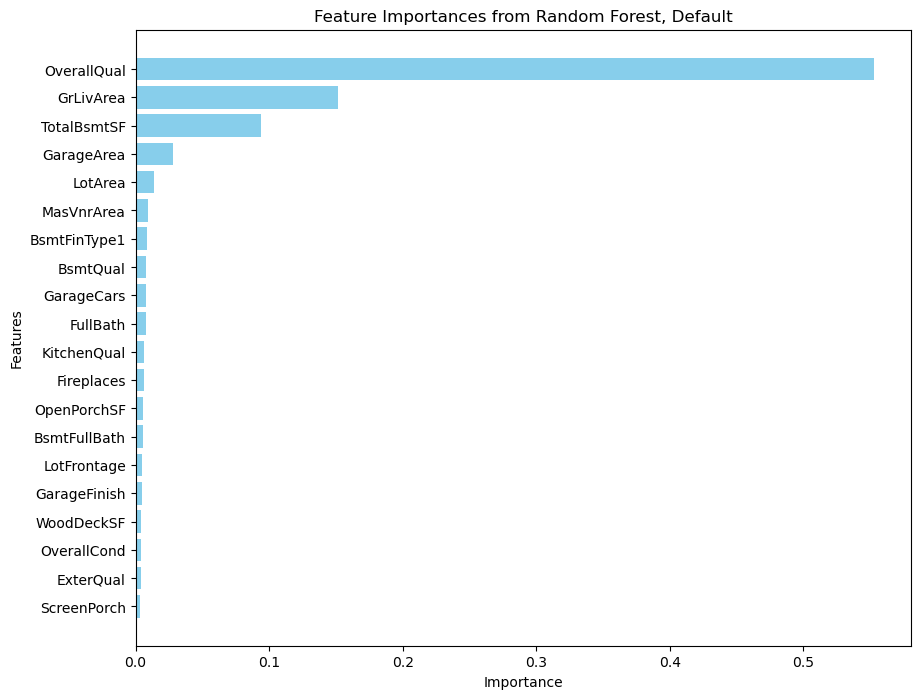

In [56]:
import matplotlib.pyplot as plt
# Sort the DataFrame by importance (if not already sorted)
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Select the top N features for a cleaner graph, you can adjust N based on your needs
top_n = 20
top_features = importance_df.head(top_n)
# Create a bar plot for the feature importances
plt.figure(figsize=(10, 8))  # Set the figure size (width, height in inches)
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Random Forest, Default')
plt.gca().invert_yaxis()  # Invert the Y-axis to show the highest values at the top
plt.show()

In [45]:
param_grid = {'regressor__n_estimators': [140, 150, 160], 
                                 'regressor__max_depth': [None],
                                 'regressor__min_samples_leaf': [1], 
                                 'regressor__max_features': [None],
                                 'regressor__min_samples_split': [2]  # Minimum number of data points allowed in a leaf node
}
from sklearn.model_selection import GridSearchCV
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=random_forest_pipeline, param_grid=param_grid, cv=kf, n_jobs=-1, verbose=2)

In [46]:
# Fit the grid search to the data
grid_search.fit(Ames.drop(columns='SalePrice'), Ames['SalePrice'])

Fitting 10 folds for each of 3 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('electrical',
                                                                         Pipeline(steps=[('impute_electrical',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal_electrical',
                                                                                          OrdinalEncoder(categories=[['Mix',
                                                                                                                      'FuseP',
                                                                                                                      'FuseF',
                                                                                                                      'FuseA',
                                                                                                                      'SBrkr']]))]),
                                                                         ['Electrical']),
                                                                        ('num',
                                                                         Pip...
                                                                          'SaleCondition',
                                                                          'SaleType',
                                                                          'Street',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'YrSold'])])),
                                       ('regressor',
                                        RandomForestRegressor(n_estimators=150,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None],
                         'regressor__max_features': [None],
                         'regressor__min_samples_leaf': [1],
                         'regressor__min_samples_split': [2],
                         'regressor__n_estimators': [140, 150, 160]},
             verbose=2)

In [47]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)
# Get the best estimator
best_rf = grid_search.best_estimator_
print("Best estimator:", best_rf)
# Optionally, review the best score (which is the mean cross-validated score of the best_estimator)
best_score = grid_search.best_score_
print("Best score (R2):", best_score)

Best parameters: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 160}
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('electrical',
                                                  Pipeline(steps=[('impute_electrical',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_electrical',
                                                                   OrdinalEncoder(categories=[['Mix',
                                                                                               'FuseP',
                                                                                               'FuseF',
                                                                                               'FuseA',
     

In [58]:
best_pipeline = grid_search.best_estimator_
# Access the RandomForestRegressor from the pipeline
best_rf = best_pipeline.named_steps['regressor']

In [59]:
# Get feature importances from the best RandomForest model
feature_importances = best_rf.feature_importances_

In [60]:
# Use the function to get feature names
feature_names = get_feature_names(best_pipeline.named_steps['preprocessor'])
# Create a DataFrame to view feature names and their corresponding importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
# Display the DataFrame
importance_df

,Feature,Importance
4,OverallQual,5.528583e-01
1,GrLivArea,1.492397e-01
7,TotalBsmtSF,9.456192e-02
17,GarageArea,2.934008e-02
3,LotArea,1.409694e-02
...,...,...
139,GarageYrBlt_1933.0,2.171730e-08
124,GarageYrBlt_1917.0,1.663688e-08
116,GarageYrBlt_1895.0,3.933097e-09
70,Condition2_RRAn,3.668981e-09


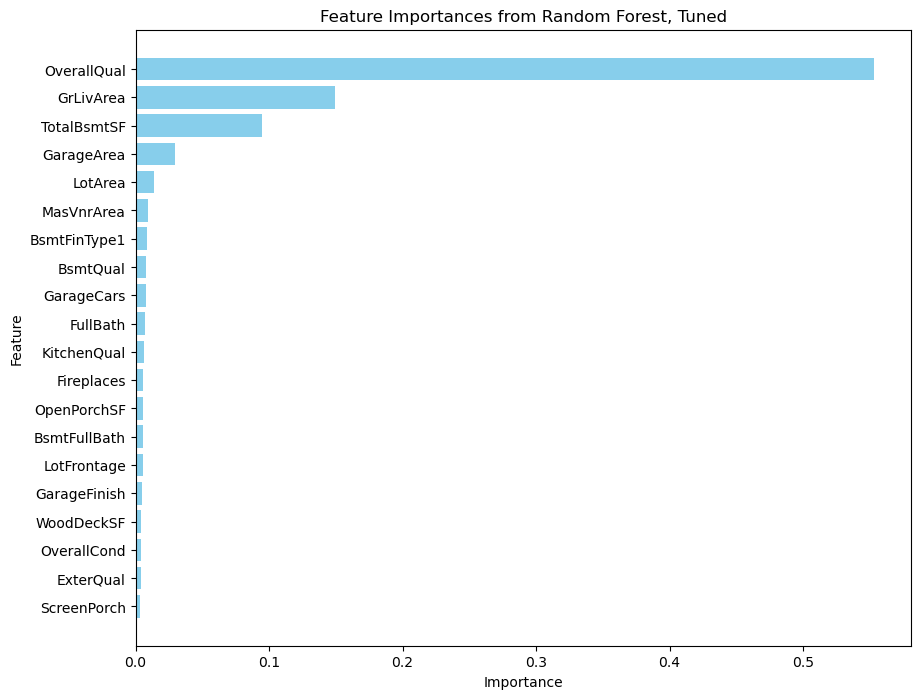

In [52]:
import matplotlib.pyplot as plt
# Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='skyblue')  # Top 20 features
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest, Tuned')
plt.gca().invert_yaxis()
plt.show()